In [73]:
import numpy as np 
import pandas as pd

In [155]:
net = np.loadtxt('networks/powergrid.edgelist.txt', dtype=int)
net

array([[   0,  386],
       [   0,  395],
       [   0,  451],
       ...,
       [4935, 4937],
       [4936, 4938],
       [4939, 4940]])

In [156]:
size = len(set([n for e in net for n in e]))

In [157]:
from scipy.sparse import csc_matrix
from scipy.sparse import lil_matrix
import scipy.sparse

A = lil_matrix((size, size), dtype=np.int32)

In [158]:
for (edge,i) in zip(net, range(len(net))):
    A[edge[0], edge[1]] = 1

In [159]:
#remove self-loops
for i in range(len(A.toarray())):
    A[i,i]=0
print('sym')
#force symmetry
for i in range(size):
    if i %1000 == 0:
        print(i/1000)
    for j in range(size):
        if A[i,j]==1:
            A[j,i]=1

sym
0.0
1.0
2.0
3.0
4.0


In [160]:
(A.toarray().transpose() == A.toarray()).all()

True

In [161]:
A = csc_matrix(A)

In [162]:
degrees=[]

for row,i in zip(A.toarray(), range(len(A.toarray()))):
    degrees.append(len(row[row==1]))

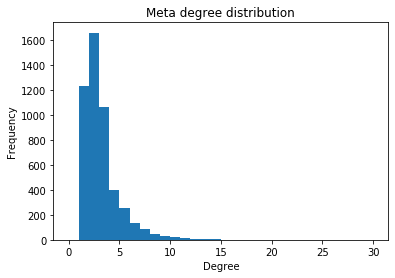

In [163]:
import matplotlib.pyplot as plt

n, bins, plot = plt.hist(degrees, bins = 30, range=[0,30])
plt.title('Meta degree distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')

plt.show()

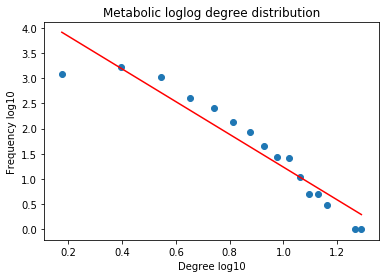

In [164]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

bins1=bins[1:]-((bins[1]-bins[0])/2)

def func(x, b, c):
    return (b*x) + c

p = np.polyfit(np.log10(bins1[1:][n[1:]>0]), np.log10(n[1:][n[1:]>0]), deg=1)


plt.scatter(np.log10(bins1[1:][n[1:]>0]), np.log10(n[1:][n[1:]>0]))
plt.plot(np.log10(bins1[1:][n[1:]>0]), func(np.log10(bins1[1:][n[1:]>0]), *p), 'r')
         
         
         
plt.title('Metabolic loglog degree distribution')
plt.xlabel('Degree log10')
plt.ylabel('Frequency log10')

plt.show()

In [165]:
n[1:][n[1:]>0]

array([1.226e+03, 1.656e+03, 1.060e+03, 4.010e+02, 2.520e+02, 1.370e+02,
       8.400e+01, 4.600e+01, 2.700e+01, 2.600e+01, 1.100e+01, 5.000e+00,
       5.000e+00, 3.000e+00, 1.000e+00, 1.000e+00])

In [166]:
A3 = A*A*A

CC = []

for i in range(len(A.toarray())):
    if degrees[i]>=2:
        CC.append(A3[i,i]/(degrees[i]*(degrees[i]-1)))
    else:
        CC.append(-1)
CC=np.array(CC)

In [167]:
np.mean(CC[CC!=-1])

0.10653888084903673

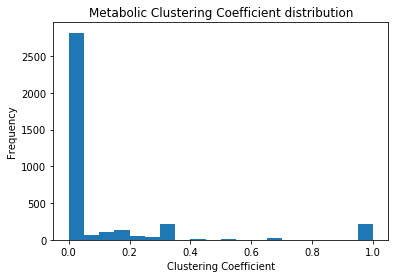

In [168]:
plt.hist(CC, bins = 20, range=[0,1])
plt.title('Metabolic Clustering Coefficient distribution')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')

plt.show()

In [169]:
from scipy.sparse.csgraph import shortest_path

dist_matrix, predecessors = shortest_path(csgraph=A, directed=False, return_predecessors=True)


In [170]:
dist_matrix

array([[ 0., 15., 18., ..., 12., 14., 13.],
       [15.,  0.,  8., ..., 19., 23., 24.],
       [18.,  8.,  0., ..., 22., 26., 27.],
       ...,
       [12., 19., 22., ...,  0., 11., 12.],
       [14., 23., 26., ..., 11.,  0.,  1.],
       [13., 24., 27., ..., 12.,  1.,  0.]])

In [171]:
shortest_values=[]
for i in range(size):
    for j in range(i, size):
        if np.isfinite(dist_matrix[i,j]):
            shortest_values.append(dist_matrix[i, j])

In [172]:
np.mean(shortest_values)

18.98150060638644

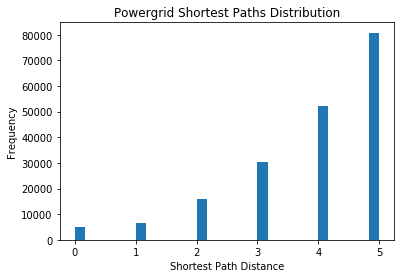

In [173]:
plt.hist(shortest_values, bins = 30, range=[0,5])
plt.title('Powergrid Shortest Paths Distribution')
plt.xlabel('Shortest Path Distance')
plt.ylabel('Frequency')
plt.show()

In [174]:
from scipy.sparse.csgraph import connected_components

n_components, labels = connected_components(A, return_labels=True)

In [175]:
n_components

1

In [176]:
size

4941

In [177]:
D = csc_matrix(np.diag(degrees), dtype=np.float)
L=D-A
L

from scipy.sparse.linalg import eigs
from scipy.sparse.linalg import eigsh

vals, vecs = eigsh(L.asfptype(), k=4940)

In [151]:
L

<2018x2018 sparse matrix of type '<class 'numpy.float64'>'
	with 7376 stored elements in Compressed Sparse Column format>

In [178]:
vals

array([7.59212211e-04, 1.08831689e-03, 1.64456371e-03, ...,
       1.55344992e+01, 1.91204000e+01, 2.01096164e+01])

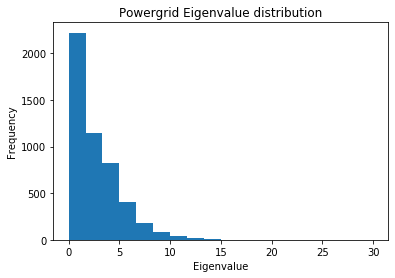

In [179]:
plt.hist(vals, bins=18, range=[0,30])
plt.title('Powergrid Eigenvalue distribution')
plt.xlabel('Eigenvalue')
plt.ylabel('Frequency')
plt.savefig('powergrid_eigs')

In [207]:
#f

x=[]
y=[]


for i in range(size):
    for j in range(i,size):
        if A[i,j]==1:
            x.append(degrees[i])
            y.append(degrees[j])

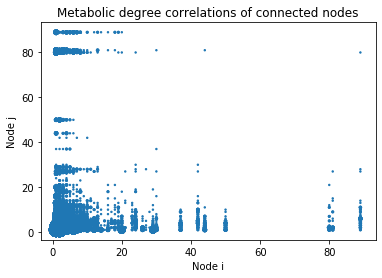

In [208]:
from collections import Counter


c = Counter(zip(x,y))

s = [2*c[(xx,yy)] for xx,yy in zip(x,y)]

# plot it
plt.scatter(x, y, s=s)
plt.title('Metabolic degree correlations of connected nodes')
plt.xlabel('Node i')
plt.ylabel('Node j')
plt.show()

In [209]:
from scipy import stats

stats.pearsonr(x, y)

(-0.08305605398629992, 1.5239963743529103e-05)

Text(0, 0.5, 'Clustering coefficient of Node i')

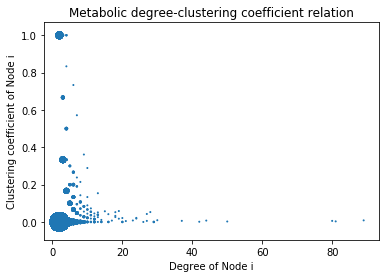

In [210]:
#e
deg = np.array(degrees)
x = deg[CC!=-1]
y = CC[CC!=-1]

c = Counter(zip(x,y))

s = [c[(xx,yy)] for xx,yy in zip(x,y)]

plt.scatter(x, y, s=s)
plt.title('Metabolic degree-clustering coefficient relation')
plt.xlabel('Degree of Node i')
plt.ylabel('Clustering coefficient of Node i')


In [217]:
size=1039

In [218]:
#AB MODEL

edges_to_add = 1

AB = lil_matrix((size, size), dtype=np.int32)
rng = np.random.default_rng()

degrees_AB=np.zeros(size)
probs_AB=np.zeros(size)

probs_AB[0]=1





for i in range(1, size):
    if i%1000 == 0:
        print(i/100)
    new_edges = rng.choice(i, edges_to_add, p=probs_AB[0:i], replace=False)
    AB[i, new_edges[0]]=1

 
    AB[new_edges[0], i]=1

    
    degrees_AB[new_edges[0]]+=1

    
    degrees_AB[i]=+edges_to_add
    
    tot_degrees = sum(degrees_AB)
    
    for j in range(0,i+1):
        probs_AB[j] = degrees_AB[j]/tot_degrees

10.0


In [219]:
np.mean(degrees)

2.66909532483303

In [220]:
np.mean(degrees_AB)

1.998075072184793

In [221]:
(AB.toarray().transpose() == AB.toarray()).all()

True

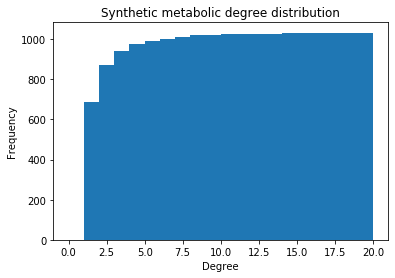

In [222]:
import matplotlib.pyplot as plt

n, bins, plot = plt.hist(degrees_AB, bins = 20, range=[0,20], cumulative=True)
plt.title('Synthetic metabolic degree distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()
        
    

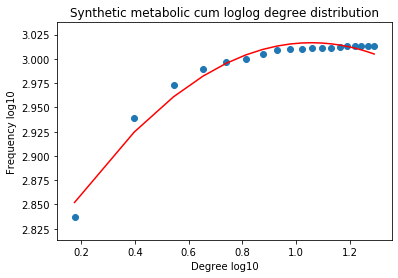

In [223]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

bins1=bins[1:]-((bins[1]-bins[0])/2)

def func(x, a, b, c):
    return a*(x**2) + (b*x) + c

p = np.polyfit(np.log10(bins1[n>0]), np.log10(n[n>0]), deg=2)


plt.scatter(np.log10(bins1[n>0]), np.log10(n[n>0]))
plt.plot(np.log10(bins1[n>0]), func(np.log10(bins1[n>0]), *p), 'r')
         
         
         
plt.title('Synthetic metabolic cum loglog degree distribution')
plt.xlabel('Degree log10')
plt.ylabel('Frequency log10')

plt.savefig('syn_meta_logdd_cum')
plt.show()

In [224]:
AB3 = AB*AB*AB

CC = []

for i in range(len(AB.toarray())):
    if degrees_AB[i]>=2:
        CC.append(AB3[i,i]/(degrees_AB[i]*(degrees_AB[i]-1)))
    else:
        CC.append(-1)
CC=np.array(CC)

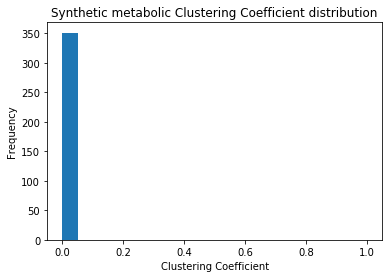

In [225]:
plt.hist(CC, bins = 20, range=[0,1])
plt.title('Synthetic metabolic Clustering Coefficient distribution')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')

plt.show()

In [226]:
from scipy.sparse.csgraph import shortest_path
AB=csc_matrix(AB)
dist_matrix, predecessors = shortest_path(csgraph=AB, directed=False, return_predecessors=True)

In [227]:
shortest_values=[]
for i in range(size):
    for j in range(i, size):
        if np.isfinite(dist_matrix[i,j]):
            shortest_values.append(dist_matrix[i, j])

In [228]:
np.mean(shortest_values)

6.6592766713555935

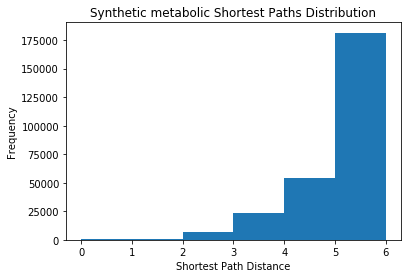

In [229]:
plt.hist(shortest_values, bins = 6, range=[0,6])
plt.title('Synthetic metabolic Shortest Paths Distribution')
plt.xlabel('Shortest Path Distance')
plt.ylabel('Frequency')

plt.show()

In [230]:
from scipy.sparse.csgraph import connected_components

n_components, labels = connected_components(AB, return_labels=True)

In [231]:
len(AB.toarray())

1039

In [232]:
D = csc_matrix(np.diag(degrees_AB))
L=D-AB
L

from scipy.sparse.linalg import eigs
from scipy.sparse.linalg import eigsh

vals, vecs = eigsh(L.asfptype(), k=1038)


In [233]:
vals

array([2.26018047e-03, 4.44800662e-03, 5.57565939e-03, ...,
       3.65236957e+01, 3.86341986e+01, 7.10441591e+01])

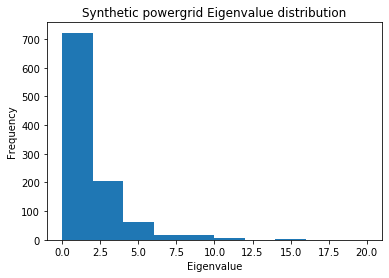

In [236]:
plt.hist(vals, bins=10, range=[0,20])
plt.title('Synthetic powergrid Eigenvalue distribution')
plt.xlabel('Eigenvalue')
plt.ylabel('Frequency')
plt.savefig('syn_powergrid_eigs')

In [237]:
#f

x=[]
y=[]

for i in range(size):
    for j in range(i,size):
        if AB[i,j]==1:
            x.append(degrees_AB[i])
            y.append(degrees_AB[j])

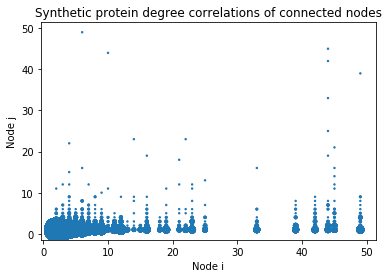

In [238]:
from collections import Counter


c = Counter(zip(x,y))

s = [2*c[(xx,yy)] for xx,yy in zip(x,y)]

# plot it
plt.scatter(x, y, s=s)
plt.title('Synthetic protein degree correlations of connected nodes')
plt.xlabel('Node i')
plt.ylabel('Node j')
plt.savefig('syn_pro_degcorr')
plt.show()

In [239]:
from scipy import stats

stats.pearsonr(x, y)

(0.21407379598765808, 2.448320161976748e-22)

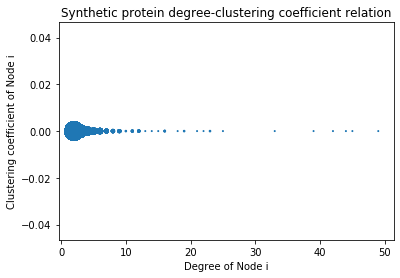

In [240]:
#e
deg = np.array(degrees_AB)
x = deg[CC!=-1]
y = CC[CC!=-1]

c = Counter(zip(x,y))

s = [c[(xx,yy)] for xx,yy in zip(x,y)]

plt.scatter(x, y, s=s)
plt.title('Synthetic protein degree-clustering coefficient relation')
plt.xlabel('Degree of Node i')
plt.ylabel('Clustering coefficient of Node i')
plt.savefig('syn_pro_degCCcorr')

In [44]:
np.sort(A.toarray().flatten())

array([0, 0, 0, ..., 1, 1, 1], dtype=int8)

In [45]:
A3 = A*A*A
np.sort(A3.toarray().flatten())

array([-128, -128, -128, ...,  127,  127,  127], dtype=int8)

In [37]:
for i,j in zip(A3.toarray().diagonal(), range(len(A2.toarray().diagonal()))):
    if i<0:
        print(j)

218
240
266
312
364
387
486
515
516
550
555
562
565
586
589
592
736
738
751
861
910


In [40]:
np.sort(A[218].toarray())

array([[0, 0, 0, ..., 1, 1, 1]], dtype=int8)

3

In [ ]:
A.toarray()[249]

In [11]:
np.sort(A.toarray()[249])

array([0, 0, 0, ..., 1, 1, 1], dtype=int8)